We want to do some preliminary calculations so that we have a framework that we can modify as needed later.  I also want to confirm how much the results of mode cooling with a warm Rydberg ensemble change when the ensemble is poorly polarized.  These results are going to assume that the math is generally identical to that of the NV ensemble i.e. we'll assume that the Holstein-Primakoff approximation is valid and that our Rydberg ensemble contains only 2 states $|r_2\rangle$ and $|r_1\rangle$ separated by $\omega_{12}=10$ GHz (the other two states $|i\rangle$ and $|g\rangle$ essentially don't contribute to the mode cooling).

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Function Definitions

In [3]:
def photons_from_temp(ω_c, temp):
    """
    function for calculating the number of photons in a mode at a given temperature
    :param ω_c:  the frequency of the mode
    :param temp: the temperature
    :return:     the number of photons
    """
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    """
    function for calculating the effective temperature of a mode with a given number of photons
    :param ω_c:          the frequency of the mode
    :param num_photons:  the number of photons in the mode
    :return:             the effective temperature of the mode
    """
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def cavity_spectrum(ω, ωc, ω12, γ, κ, g, nT, nc):
    """
    function for calculating the cavity mode spectrum of the cavity-rydberg setup
    :param ω:   the spectrum frequency
    :param ωc:  the cavity mode frequency
    :param ω12: the transition frequency between the |r1> and |r2> states
    :param γ:   the output coupling of the cavity
    :param κ:   the inhomogenous broadening of the rydberg atoms
    :param g:   the cavity-rydberg coupling strength
    :param nT:  the number of thermal photons in the cavity mode expected from the temperature
    :param nc:  the effective number of photons in the rydberg ensemble
    """
    # Calculate the numerator and denominator
    num = (κ ** 2 / 4 + (ω - ω12) ** 2) * γ * nT + κ * g ** 2 * nc
    den = np.abs((γ / 2 - 1j * (ω - ωc)) * (κ / 2 - 1j * (ω - ω12)) + g ** 2) ** 2

    return num / den

In [6]:
def cav_photons(γ, κ, g, nT, nc):
    """
    function for calculating the number of photons in the cavity mode using Gradstein's formula.  Note that ωc = ω12 = 0 for this to hold
    :param γ:   the output coupling of the cavity
    :param κ:   the inhomogenous broadening of the rydberg atoms
    :param g:   the cavity-rydberg coupling strength
    :param nT:  the number of thermal photons in the cavity mode expected from the temperature
    :param nc:  the effective number of photons in the rydberg ensemble
    """
    num = (γ ** 2 * κ / 4 + γ * g ** 2 + γ * κ ** 2 / 4) * nT + κ * g ** 2 * nc
    den = γ * κ ** 2 / 4 + κ * g ** 2 + γ ** 2 * κ / 4 + γ * g ** 2
    return num / den

In [7]:
def output_spectrum(ω, ωc, ω12, γ, κ, g, nT, nc):
    """
    function for calculating the output spectrum of the cavity-rydberg setup
    :param ω:   the spectrum frequency
    :param ωc:  the cavity mode frequency
    :param ω12: the transition frequency between the |r1> and |r2> states
    :param γ:   the output coupling of the cavity
    :param κ:   the inhomogenous broadening of the rydberg atoms
    :param g:   the cavity-rydberg coupling strength
    :param nT:  the number of thermal photons in the cavity mode expected from the temperature
    :param nc:  the effective number of photons in the rydberg ensemble
    """
    # Calculate the numerator in parts
    a = np.abs((γ / 2 + 1j * (ω - ωc)) * (κ / 2 - 1j * (ω - ω12)) - g ** 2) ** 2 * nT
    b = κ * g ** 2 * nc
    num = a + b

    # Calculate denominator
    den = np.abs((γ / 2 - 1j * (ω - ωc)) * (κ / 2 - 1j * (ω - ω12)) + g ** 2) ** 2

    return num / den

## Results
For now, we'll assume that $\omega_c = \omega_{12} = 10$ GHz to make things a bit simpler.  We'll also just assume that the coupling strength is the same as the quality factor of the cavity, which should be around 1000.  This value will be easy to update with more concrete values for the mode volume and the dipole moment of the rydberg system.

In [63]:
# Define parameters
ωc = 2 * np.pi * 10e9           # The cavity mode frequency
ω12 = ωc                        # The transition frequency
Q = 1e3                         # The quality factor of the cavity mode
γ = ωc / Q                      # The output coupling of the cavity
g = Q                           # The cavity-rydberg coupling rate
κ = 2 * g                       # The inhomegenous broadening of the rydberg ensemble
T  = 300                        # The environmental temperature of the setup
nT = photons_from_temp(ωc, T)   # The number of thermal photons from the temperature

In [64]:
# Consider both a highly polarized and poorly polarized ensemble
high_P = 1
high_nc = 0.5 * (1 - high_P) / high_P

low_P = 0.1
low_nc = 0.5 * (1 - low_P) / low_P

In [65]:
# Define ω range to plot spectrum over - say [-5, 5] MHz
ω = 2 * np.pi * np.linspace(-5, 5, 1000) * 1e6

In [66]:
# Calculate spectra
low_cav_spec = cavity_spectrum(ω, 0, 0, γ, κ, g, nT, low_nc)
high_cav_spec = cavity_spectrum(ω, 0, 0, γ, κ, g, nT, high_nc)

low_out_spec = output_spectrum(ω, 0, 0, γ, κ, g, nT, low_nc)
high_out_spec = output_spectrum(ω, 0, 0, γ, κ, g, nT, high_nc)

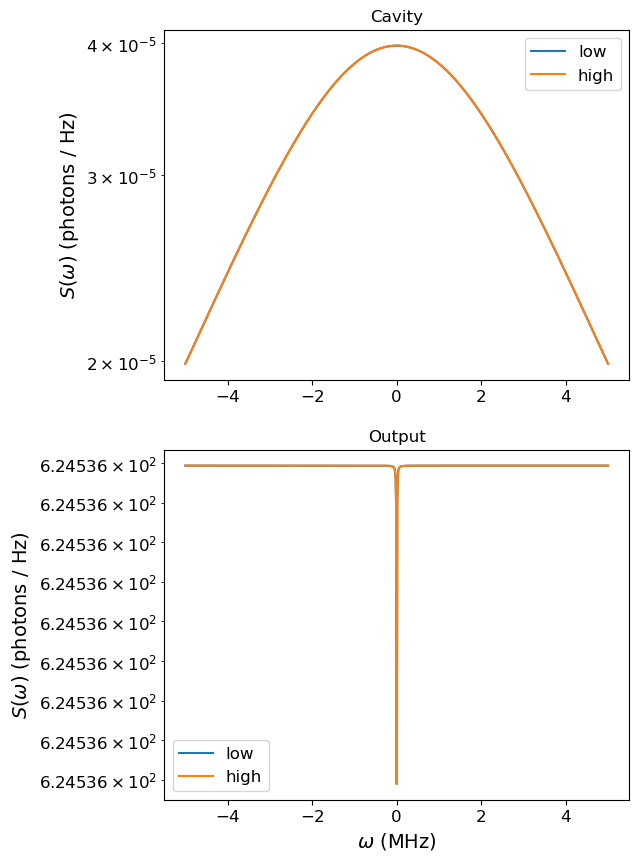

In [67]:
# Plot
fig = plt.figure(1, figsize=(6, 10))
ax = fig.subplots(2, 1)
ax[0].plot(ω / (2 * np.pi * 1e6), low_cav_spec, label='low')
ax[0].plot(ω / (2 * np.pi * 1e6), high_cav_spec, label='high')
#ax[0].set_xlabel("$\\omega$ (MHz)")
ax[0].set_ylabel("$S(\\omega)$ (photons / Hz)")
ax[0].set_title("Cavity")
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(ω / (2 * np.pi * 1e6), low_out_spec, label='low')
ax[1].plot(ω / (2 * np.pi * 1e6), high_out_spec, label='high')
ax[1].set_xlabel("$\\omega$ (MHz)")
ax[1].set_ylabel("$S(\\omega)$ (photons / Hz)")
ax[1].set_title("Output")
ax[1].set_yscale('log')
ax[1].legend()

In [53]:
low_n = cav_photons(γ, κ, g, nT, low_nc)
high_n = cav_photons(γ, κ, g, nT, high_nc)

In [54]:
print("Avg. cavity photons with low P: ", low_n)
print("Avg. cavity photons with high P: ", high_n)
print("Thermal photons: ", nT)

Avg. cavity photons with low P:  624.5358465288398
Avg. cavity photons with high P:  624.5358460731846
Thermal photons:  624.5359093116369


In [55]:
print("Low P temp: ", temp_from_photons(ωc, low_n))
print("High P temp: ", temp_from_photons(ωc, high_n))

Low P temp:  299.9999698659432
High P temp:  299.9999696472478


From these results, we can see that the polarization doesn't really impact the cooling at all.  Unfortunately, we can also see that we aren't really cooling anything down here either.  This is interesting because Kurt's paper with the NV ensemble does indicate cooling at room temperature with 'worse' parameters than I'm using here.  It might just be that I'm looking at the cavity mode here.  In Kurt's paper, they only refer to the output spectrum in their results.

It's also worth noting that in the NV ensemble, $g$ is typically larger than 1000.  Kurt's paper has $g\sim 1$ MHz for instance.  Let's see what kind of $g$ we would need to see appreciable cooling in the spectrum.

In [69]:
# Let g vary from Q to 10^4 Q
g = np.array([1e3, 1e4, 1e5, 1e6, 1e7])
κ = 2 * g

# We saw that changing P didn't really impact the results before, so we'll just pick 0.5 for now
P = 0.5
nc = 0.5 * (1 - P) / P

In [70]:
S_out = np.zeros((g.shape[0], ω.shape[0]))
for i in range(g.shape[0]):
    S_out[i] = output_spectrum(ω, 0, 0, γ, κ[i], g[i], nT, nc)

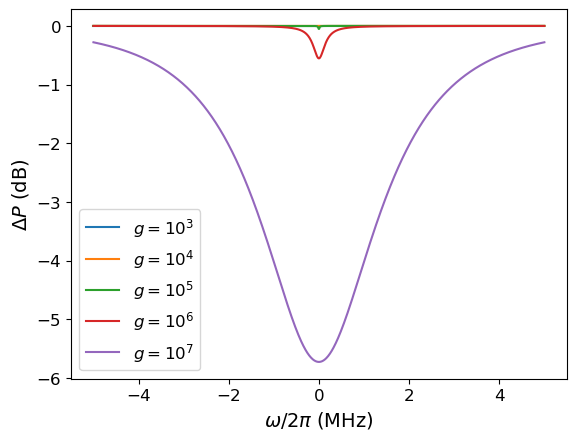

In [75]:
for i in range(g.shape[0]):
    plt.plot(ω / (2 * np.pi * 1e6), 10*np.log10(S_out[i]/nT), label='$g=10^'+str(i+3)+'$')
plt.xlabel("$\\omega / 2\\pi$ (MHz)")
plt.ylabel("$\\Delta P$ (dB)")
plt.legend()

In [76]:
# Let's take the on resonance values and convert to temperature to get a feel for how much we cooled the mode by
S_out = np.zeros(g.shape[0])
for i in range(g.shape[0]):
    S_out[i] = output_spectrum(0, 0, 0, γ, κ[i], g[i], nT, nc)

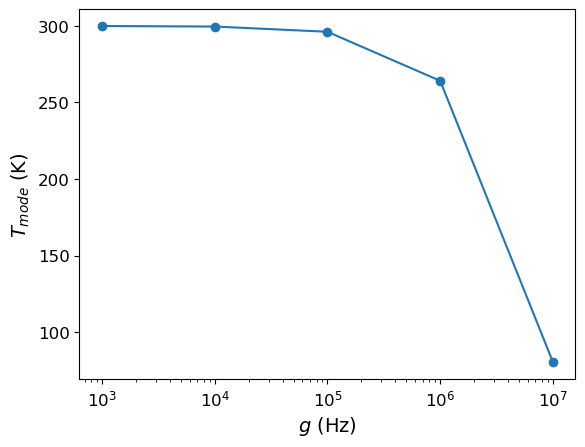

In [78]:
nS = temp_from_photons(ωc, S_out)
plt.plot(g, nS, 'o-')
plt.xlabel("$g$ (Hz)")
plt.ylabel("$T_{mode}$ (K)")
plt.xscale('log')

So this suggests that we would want $g \geq 1$ MHz to get appreciable cooling with $Q = 1000$.  It is worth pointing out that the other parameters could change as well.  So far, I've assumed that we only have one input and that the noise is due to the internal loss of the cavity.  If we were to make the input port separate from the internal loss, we could tweak the values to see if there's some output coupling that enhances the mode cooling for a fixed internal loss rate.